In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文显示
plt.rcParams['axes.unicode_minus'] = False

In [91]:
# ========== 2. 数据加载与预处理 ==========
def load_and_preprocess():
    # 加载数据
    df_train = pd.read_csv("data/train_FD001.txt", sep=' ', header=None) 
    # 定义列名
    col_names = [
        'unit', 'time', 
        'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
        [f'sm_{i}' for i in range(1,22)]
    
    # 去除空列并设置列名
    df_train = df_train.dropna(axis=1, how='all')
    df_train.columns = col_names[:df_train.shape[1]]
    
    # 选择文献中的14个关键传感器
    selected_sensors = [
        'sm_2', 'sm_3', 'sm_4',   # 温度相关
        'sm_7', 'sm_8', 'sm_9',   # 压力相关
        'sm_11', 'sm_12', 'sm_13', # 转速相关
        'sm_14', 'sm_15', 'sm_17', # 燃油相关
        'sm_20', 'sm_21'          # 冷气流量
    ]
    
    # 验证列名
    missing = [s for s in selected_sensors if s not in df_train.columns]
    if missing:
        raise ValueError(f"缺失必要传感器列：{missing}")

    # 按发动机分组并归一化
    engines = []
    for engine_id in df_train['unit'].unique():
        engine_data = df_train[df_train['unit'] == engine_id][selected_sensors]
        # 独立归一化每个发动机
        engines.append(minmax_scale(engine_data, feature_range=(-1, 1)))
    
    return engines

In [92]:
# ========== 3. 构建VAE模型 ==========
class VAEDetector:
    def __init__(self, input_dim, latent_dim=2):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self._build_model()
    
    def _build_model(self):
        # 编码器
        inputs = Input(shape=(self.input_dim,))
        x = Dense(16, activation='relu')(inputs)
        x = Dense(8, activation='relu')(x)
        
        # 潜在空间分布参数
        z_mean = Dense(self.latent_dim)(x)
        z_log_var = Dense(self.latent_dim)(x)
        
        # 重参数化采样
        def sampling(args):
            z_mean, z_log_var = args
            epsilon = K.random_normal(shape=(K.shape(z_mean)[0], self.latent_dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon
        
        z = Lambda(sampling)([z_mean, z_log_var])
        
        # 解码器
        decoder_input = Input(shape=(self.latent_dim,))
        d = Dense(8, activation='relu')(decoder_input)
        d = Dense(16, activation='relu')(d)
        outputs = Dense(self.input_dim, activation='tanh')(d)
        
        # 完整模型
        self.encoder = Model(inputs, z_mean)
        self.decoder = Model(decoder_input, outputs)
        self.vae = Model(inputs, self.decoder(z))
        
        # 自定义损失函数
        reconstruction_loss = K.mean(K.square(inputs - self.vae.output), axis=-1)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        self.vae.add_loss(K.mean(reconstruction_loss + kl_loss))
        self.vae.compile(optimizer='adam')

In [93]:
def find_anomaly_start(engine_data, smooth_window=15, detect_window_ratio=0.1, upper_sigma=3.0, lower_sigma=3.0):
    """
    参数：
        smooth_window: 平滑窗口大小 
        detect_window_ratio: 检测窗口占总周期的比例
    """
    # 计算原始重构误差
    reconstructions = detector.vae.predict(engine_data)
    mse = np.mean(np.square(engine_data - reconstructions), axis=1)
    
    # 滑动窗口平滑（使用卷积实现）
    window = np.ones(smooth_window)/smooth_window
    smoothed = np.convolve(mse, window, mode='valid')
    
    # 计算动态阈值（基于前20%的平滑数据）
    baseline_len = max(int(len(smoothed)*0.2), 5)  # 修正基线长度计算
    baseline = smoothed[:baseline_len]
    b_mean = np.mean(baseline)
    b_std = np.std(baseline)
    upper_thresh = b_mean + upper_sigma * b_std
    lower_thresh = b_mean - lower_sigma * b_std
    
    # 确定检测窗口大小（基于原始周期比例）
    detect_window = max(int(len(mse) * detect_window_ratio), 1)
    
    # 寻找所有超界点（基于平滑误差）
    # 生成对应关系数组
    exceed_points = np.where((smoothed > upper_thresh) | (smoothed < lower_thresh))[0]
    original_indices = exceed_points + (smooth_window - 1)
    
    # 使用迭代器同时遍历两个数组
    for idx, (smooth_idx, original_idx) in enumerate(zip(exceed_points, original_indices)):
        end_idx = smooth_idx + detect_window
        
        if end_idx >= len(smoothed):
            continue
            
        window_smoothed = smoothed[smooth_idx:end_idx]
        if np.all((window_smoothed > upper_thresh) | (window_smoothed < lower_thresh)):
            return original_idx  # 直接返回对应的原始索引
        
    return original_indices[-1] if len(original_indices) > 0 else len(mse)


In [94]:
def visualize_detection(engine_id, engines, starts, detect_window_ratio):
    engine_data = engines[engine_id]
    start_point = starts[engine_id]
    total_cycles = len(engine_data)
    detect_window = int(total_cycles * detect_window_ratio)
    
    # 误差计算（保持与检测函数一致）
    reconstructions = detector.vae.predict(engine_data)
    mse = np.mean(np.square(engine_data - reconstructions), axis=1)
    smooth_window = DETECT_PARAMS['smooth_window']
    window = np.ones(smooth_window)/smooth_window
    smoothed = np.convolve(mse, window, mode='valid')
    
    # 阈值计算（保持与检测函数一致）
    baseline_len = max(int(len(smoothed)*0.2), 5)
    baseline = smoothed[:baseline_len]
    b_mean = np.mean(baseline)
    b_std = np.std(baseline)
    upper_thresh = b_mean + 3 * b_std
    lower_thresh = b_mean - 3 * b_std
    
    plt.figure(figsize=(15, 6))
    
    # 传感器数据面板
    plt.subplot(121)
    for i in range(3):  # 显示前3个传感器
        plt.plot(engine_data[:, i], alpha=0.6, label=f'Sensor {i+1}')
    plt.axvline(start_point, color='r', linestyle='--', 
               linewidth=2, label='检测起点')
    plt.xlabel('运行周期')
    plt.ylabel('归一化值')
    plt.title(f'发动机 {engine_id+1}\n总周期: {total_cycles} 检测窗口: {detect_window}')
    plt.legend()
    
    # 误差分析面板
    plt.subplot(122)
    plt.plot(mse, label='原始误差', color='blue', alpha=0.3)
    plt.plot(range(smooth_window-1, len(mse)), smoothed, label='平滑MSE', color='orange')
    
    # 绘制检测窗口
    if start_point + detect_window <= len(mse):
        plt.axvspan(start_point, start_point + detect_window, 
                   facecolor='orange', alpha=0.3, label='检测窗口')
    
    # 绘制阈值线
    plt.axhline(upper_thresh, color='green', linestyle=':', label='上阈值')
    plt.axhline(lower_thresh, color='purple', linestyle=':', label='下阈值')
    plt.axhline(b_mean, color='gray', linestyle='--', label='基线均值')
    
    plt.xlabel('运行周期')
    plt.ylabel('重构误差')
    plt.title('异常检测分析（平滑后）')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [95]:
# 参数配置
DETECT_PARAMS = {
    'smooth_window': 15,       
    'detect_window_ratio': 0.1,  # 检测窗口比例
    'upper_sigma': 3,        # 稍微降低sigma值提高灵敏度
    'lower_sigma': 3
}
# 加载数据
engines = load_and_preprocess()
print(f"成功加载 {len(engines)} 台发动机数据")

成功加载 100 台发动机数据


In [96]:
# 训练VAE
detector = VAEDetector(input_dim=engines[0].shape[1])
print("训练VAE中...")
detector.vae.fit(np.vstack(engines), epochs=50, batch_size=32, verbose=1)

训练VAE中...
Epoch 1/50
645/645 [==============================] - 1s 1ms/step - loss: 0.1900
Epoch 2/50
645/645 [==============================] - 1s 1ms/step - loss: 0.1757
Epoch 3/50
645/645 [==============================] - 1s 1ms/step - loss: 0.1753
Epoch 4/50
645/645 [==============================] - 1s 1ms/step - loss: 0.1752
Epoch 5/50
645/645 [==============================] - 1s 1ms/step - loss: 0.1752
Epoch 6/50
645/645 [==============================] - 1s 1ms/step - loss: 0.1752
Epoch 7/50
645/645 [==============================] - 1s 1ms/step - loss: 0.1752
Epoch 8/50
645/645 [==============================] - 1s 1ms/step - loss: 0.1751
Epoch 9/50
645/645 [==============================] - 1s 2ms/step - loss: 0.1751
Epoch 10/50
645/645 [==============================] - 1s 2ms/step - loss: 0.1752
Epoch 11/50
645/645 [==============================] - 1s 2ms/step - loss: 0.1751
Epoch 12/50
645/645 [==============================] - 1s 2ms/step - loss: 0.1751
Epoch 13/50
645

In [97]:
# 执行检测
anomaly_starts = []
for i, engine in enumerate(engines):
    start = find_anomaly_start(engine, **DETECT_PARAMS)
    anomaly_starts.append(start)
    print(f"发动机 {i+1:03d} | 总周期: {len(engine):3d} | 异常起点: {start:3d}")

6/6 [==============================] - 0s 1ms/step
发动机 001 | 总周期: 192 | 异常起点:  80
9/9 [==============================] - 0s 1ms/step
发动机 002 | 总周期: 287 | 异常起点:  98
6/6 [==============================] - 0s 1ms/step
发动机 003 | 总周期: 179 | 异常起点:  54
6/6 [==============================] - 0s 1ms/step
发动机 004 | 总周期: 189 | 异常起点:  69
9/9 [==============================] - 0s 1ms/step
发动机 005 | 总周期: 269 | 异常起点:  81
6/6 [==============================] - 0s 1ms/step
发动机 006 | 总周期: 188 | 异常起点:  57
9/9 [==============================] - 0s 1ms/step
发动机 007 | 总周期: 259 | 异常起点:  82
5/5 [==============================] - 0s 2ms/step
发动机 008 | 总周期: 150 | 异常起点:  70
7/7 [==============================] - 0s 2ms/step
发动机 009 | 总周期: 201 | 异常起点:  60
7/7 [==============================] - 0s 2ms/step
发动机 010 | 总周期: 222 | 异常起点:  62
8/8 [==============================] - 0s 1ms/step
发动机 011 | 总周期: 240 | 异常起点:  68
6/6 [==============================] - 0s 2ms/step
发动机 012 | 总周期: 170 | 异常起点:  89
6/6 [===========

7/7 [==============================] - 0s 1ms/step


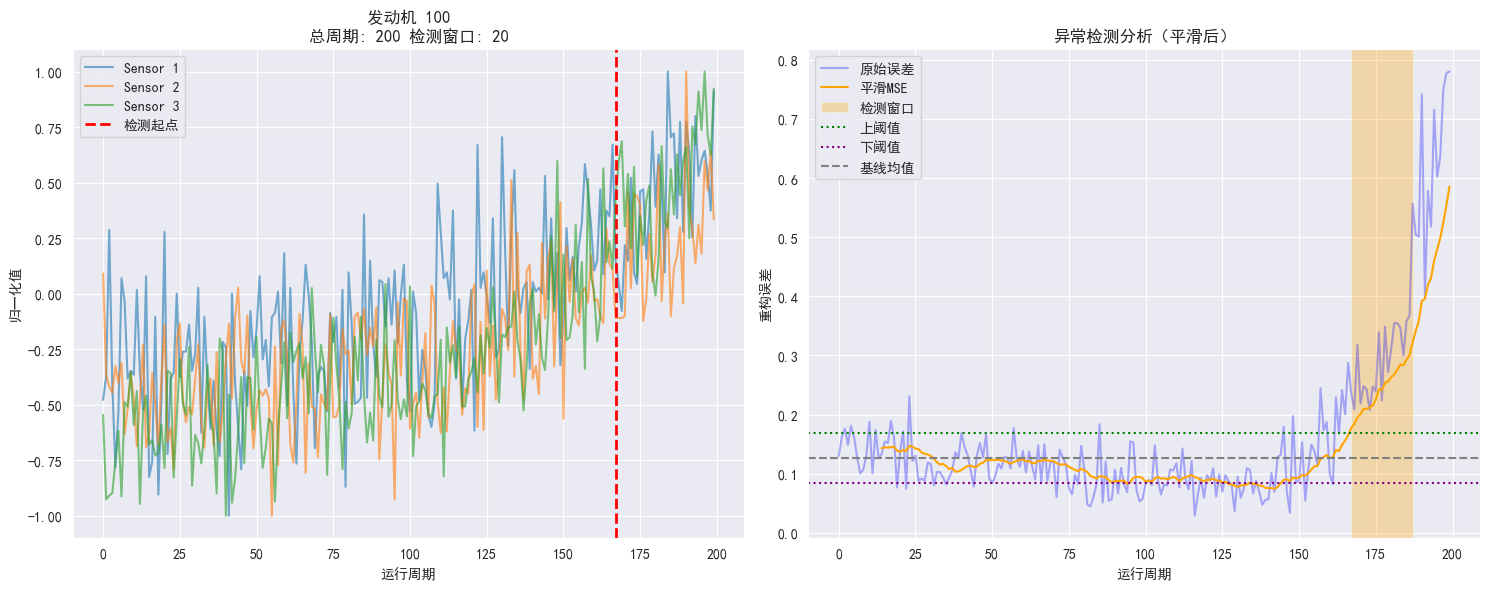

In [102]:
# 可视化发动机
visualize_detection(99, engines, anomaly_starts, DETECT_PARAMS['detect_window_ratio'])